# 2024 Fall CS180 Project 2

In [1]:
''' Here are all the libraries used in this project. '''
import cv2
import scipy
import numpy as np
import skimage as sk
import skimage.io as skio
import matplotlib.pyplot as plt

## Fun with Filters and Frequencies!

### Part 1: Fun with Filters

In [2]:
''' Here are some important functions used in this part. '''
# Save the normalized image.
def save_normalized_image(image, imname):
    im_normalized = (image - image.min()) / (image.max() - image.min())
    im_uint8 = (im_normalized * 255).astype(np.uint8)
    fname = f'./output/{imname}.jpg'
    skio.imsave(fname, im_uint8)
    return im_uint8

# Crop the two image to keep them in the same shape.
def cropXY(x, y):
    min_shape = (min(x.shape[0], y.shape[0]), min(x.shape[1], y.shape[1]))
    return x[:min_shape[0], :min_shape[1]], y[:min_shape[0], :min_shape[1]]

# Compute the gradient magnitude image and generate the edge image.
def gradient_edge(grad_x, grad_y, threshold, fname=''):
    # Compute the gradient magnitude image.
    gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)
    gradient_magnitude_img = save_normalized_image(gradient_magnitude, f'gradient_magnitude{fname}')

    # Set the appropriate threshold to binarize.
    edge = gradient_magnitude > threshold
    edge_image = sk.img_as_ubyte(edge)
    skio.imsave(f'./output/edge_image{fname}.jpg', edge_image)

    fig, axes = plt.subplots(1, 2, figsize=(7, 5))
    axes[0].imshow(gradient_magnitude_img, cmap='gray')
    axes[0].set_title('Gradient Magnitude Image')
    axes[0].axis('off')
    axes[1].imshow(edge_image, cmap='gray')
    axes[1].set_title('Binary Edge Image')
    axes[1].axis('off')
    plt.show()

    return gradient_magnitude, edge_image

#### Part 1.1: Finite Difference Operator

&emsp;&emsp;In this part, the humble finite difference is used as our filter in the $x$ and $y$ directions.
$$
    D_{x} = 
    \begin{bmatrix}
        1 & -1 \\
    \end{bmatrix}
    ~~~~~~~~
    D_{y} = 
    \begin{bmatrix}
        1 \\
        -1 \\
    \end{bmatrix}
$$

The partial derivatives in Dx and Dy of the cameraman image:


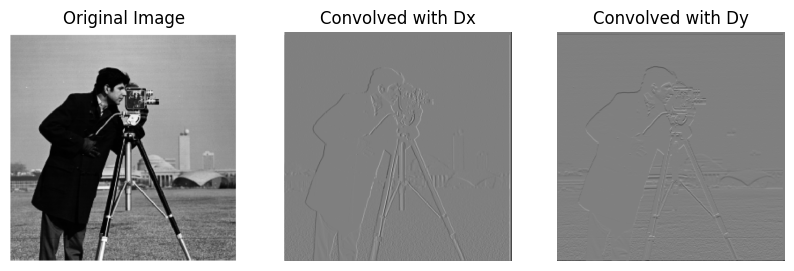

In [3]:
imname = './media/cameraman.png'
im = skio.imread(imname, as_gray=True)
im = sk.img_as_float(im)

# Convolve the image with finite difference operators Dx and Dy.
Dx = np.array([[1, -1]])
Dy = np.array([[1], 
               [-1]])
grad_x = scipy.signal.convolve2d(im, Dx)
grad_y = scipy.signal.convolve2d(im, Dy)
grad_x_img = save_normalized_image(grad_x, 'partial_derivative_x')
grad_y_img = save_normalized_image(grad_y, 'partial_derivative_y')
grad_x, grad_y = cropXY(grad_x, grad_y)

print('The partial derivatives in Dx and Dy of the cameraman image:')
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes[0].imshow(im, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(grad_x_img, cmap='gray')
axes[1].set_title('Convolved with Dx')
axes[1].axis('off')
axes[2].imshow(grad_y_img, cmap='gray')
axes[2].set_title('Convolved with Dy')
axes[2].axis('off')
plt.show()

&emsp;&emsp;To compute the gradient magnitude image, consider the formula mentioned in the course:
$$
\|\nabla f\| = \sqrt{\left(\frac{\partial f}{\partial x}\right)^{2} + \left(\frac{\partial f}{\partial y}\right)^{2}}.
$$
&emsp;&emsp;To binarize the gradient magnitude image, I choose the threshold $\epsilon = 0.26$. All pixels with values greater than the threshold are set to 1, while others are set to 0.

The results are shown below:


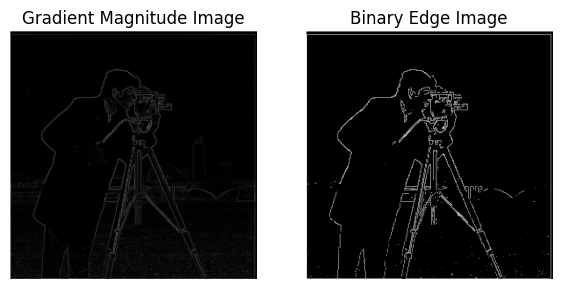

In [4]:
print('The results are shown below:')
gradient_magnitude, edge_image = gradient_edge(grad_x, grad_y, 0.26)

#### Part 1.2: Derivative of Gaussian (DoG) Filter

&emsp;&emsp;Here are the related parameters in this part:
$$
    \textbf{Gaussian filter: } \sigma = 1 \text{ with } 9 \times 9 \text{ kernel}
$$
$$
    \textbf{Threshold } \text{for edge binarization: 0.065}
$$

In [5]:
sigma = 1
kernel_size = 9
gaussian_1d = cv2.getGaussianKernel(kernel_size, sigma)
gaussian_2d = gaussian_1d * gaussian_1d.T

##### Method 1: Create a blurred version of the original image by convolving with a gaussian before applying $D_{x}$, $D_{y}$ operators.

The partial derivatives in Dx and Dy of the blurred cameraman image:


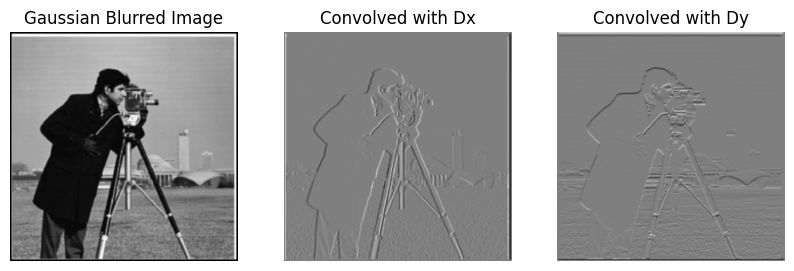

The gradient magnitude image and edge image:


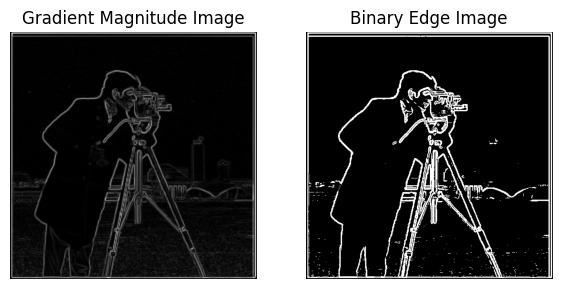

In [6]:
blurred = scipy.signal.convolve2d(im, gaussian_2d)
save_normalized_image(blurred, 'blurred')

grad_x = scipy.signal.convolve2d(blurred, Dx)
grad_y = scipy.signal.convolve2d(blurred, Dy)
grad_x_img = save_normalized_image(grad_x, 'partial_derivative_x_blurred')
grad_y_img = save_normalized_image(grad_y, 'partial_derivative_y_blurred')
grad_x, grad_y = cropXY(grad_x, grad_y)

print('The partial derivatives in Dx and Dy of the blurred cameraman image:')
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes[0].imshow(blurred, cmap='gray')
axes[0].set_title('Gaussian Blurred Image')
axes[0].axis('off')
axes[1].imshow(grad_x_img, cmap='gray')
axes[1].set_title('Convolved with Dx')
axes[1].axis('off')
axes[2].imshow(grad_y_img, cmap='gray')
axes[2].set_title('Convolved with Dy')
axes[2].axis('off')
plt.show()

print('The gradient magnitude image and edge image:')
gradient_magnitude1, edge1 = gradient_edge(grad_x, grad_y, 0.065, '_blurred')

&emsp;&emsp;Compared with the edge image in Part 1.1, all the edges and lines are bolder now which helps us to identify the edge much clearer.

##### Method 2: Convolve the gaussian with $D_{x}$ and $D_{y}$ and apply the resulting DoG filters to the original image.

The DoG filters and partial derivatives in Dx and Dy:


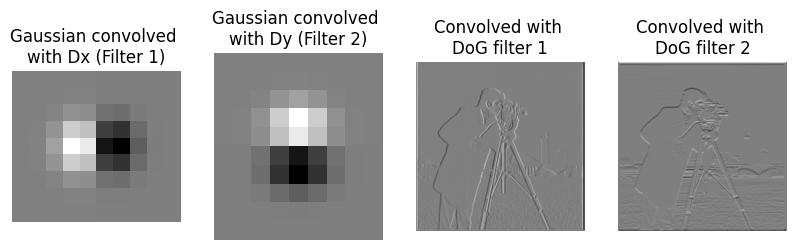

The gradient magnitude image and edge image:


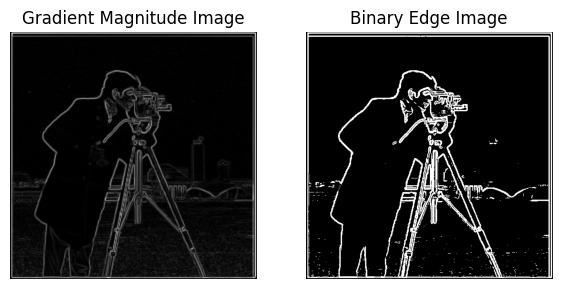

In [7]:
# Generate and save the DoG filters.
DoG_x = scipy.signal.convolve2d(gaussian_2d, Dx)
DoG_y = scipy.signal.convolve2d(gaussian_2d, Dy)
save_normalized_image(DoG_x, 'DoG_x')
save_normalized_image(DoG_y, 'DoG_y')

# Compute the gradient.
grad_x_DoG = scipy.signal.convolve2d(im, DoG_x)
grad_y_DoG = scipy.signal.convolve2d(im, DoG_y)
save_normalized_image(grad_x_DoG, 'partial_derivative_x_DoG')
save_normalized_image(grad_y_DoG, 'partial_derivative_y_DoG')
grad_x_DoG, grad_y_DoG = cropXY(grad_x_DoG, grad_y_DoG)

print('The DoG filters and partial derivatives in Dx and Dy:')
fig, axes = plt.subplots(1, 4, figsize=(10, 5))
axes[0].imshow(DoG_x, cmap='gray')
axes[0].set_title('Gaussian convolved \nwith Dx (Filter 1)')
axes[0].axis('off')
axes[1].imshow(DoG_y, cmap='gray')
axes[1].set_title('Gaussian convolved \nwith Dy (Filter 2)')
axes[1].axis('off')
axes[2].imshow(grad_x_DoG, cmap='gray')
axes[2].set_title('Convolved with \nDoG filter 1')
axes[2].axis('off')
axes[3].imshow(grad_y_DoG, cmap='gray')
axes[3].set_title('Convolved with \nDoG filter 2')
axes[3].axis('off')
plt.show()

print('The gradient magnitude image and edge image:')
gradient_magnitude2, edge2 = gradient_edge(grad_x_DoG, grad_y_DoG, 0.065, '_DoG')

Then verify that the edge images generated by mthod 1 and method 2 are the same.

In [8]:
# Verify that the edge images are the same.
if np.array_equal(edge1, edge2):
    print("The two edge images are identical.")
else:
    print("The two edge images are different.")

The two edge images are identical.


### Part 2: Fun with Frequencies!

#### Part 2.1: Image "Sharpening"

&emsp;&emsp;By subtracting the blurred version from the original image, we can isolate the high-frequency details. An image often looks sharper if it has stronger high frequencies. To enhance this effect, we can increase the high-frequency content. This process can be combined into a single convolution operation known as the unsharp mask filter. In other words, we have
$$
    \text{Image - Blurred = High Frequency (Details)}
$$
$$
    \text{Image + } \alpha \cdot \text{High Frequency = Sharpened}
$$

In [9]:
# Sharpen the input image.
def sharpen(imname, kernel_size, sigma, alpha, to_plot=True):
    im = skio.imread(imname)
    im = sk.img_as_float(im)
    fname = (imname.split('.')[1]).split('/')[2]

    # Apply Gaussian Blur.
    blurred = cv2.GaussianBlur(im, kernel_size, sigma)
    blurred_img = save_normalized_image(blurred, f'blur_{fname}')

    # Compute the high frequency part.
    high_freq = im - blurred
    high_freq_img = save_normalized_image(high_freq, f'high_freq_{fname}')

    # Sharpen the image using the parameter alpha.
    sharpened = im + alpha * high_freq
    sharpened_img = sk.img_as_ubyte(np.clip(sharpened, 0, 1))
    skio.imsave(f'./output/sharpened_{fname}.jpg', sharpened_img)

    if to_plot:
        fig, axes = plt.subplots(1, 4, figsize=(15, 5))
        axes[0].imshow(im)
        axes[0].set_title('Original Image')
        axes[0].axis('off')
        axes[1].imshow(blurred_img)
        axes[1].set_title('Blurred Image')
        axes[1].axis('off')
        axes[2].imshow(high_freq_img)
        axes[2].set_title('High Frequency')
        axes[2].axis('off')
        axes[3].imshow(sharpened_img)
        axes[3].set_title('Sharpened Image')
        axes[3].axis('off')
        plt.show()
    else:
        return im, blurred_img, sharpened_img

Here are the results on the given image and the image of my choice:

The results of taj.jpg:


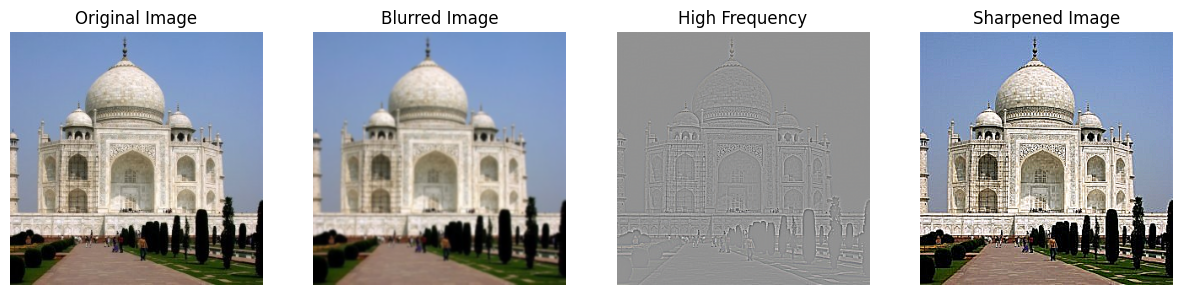

In [10]:
print('The results of taj.jpg:')
sharpen('./media/taj.jpg', (9, 9), 1, 3)

The results of flower.jpg:


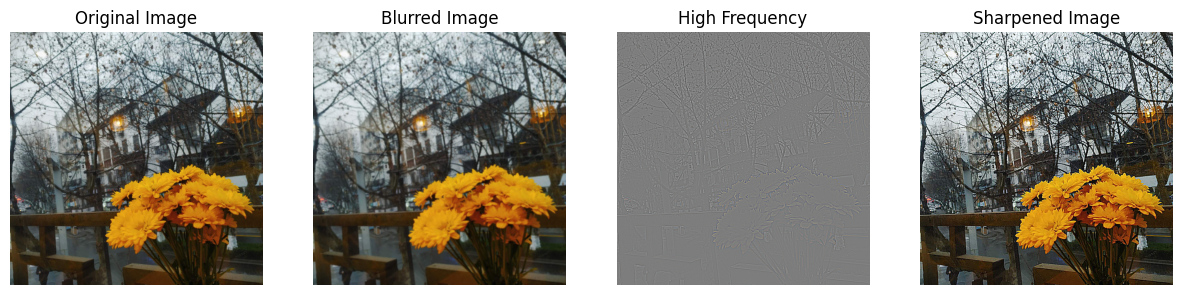

In [11]:
print('The results of flower.jpg:')
sharpen('./media/flower.jpg', (9, 9), 2, 4)

&emsp;&emsp;For evaluation, I also pick a sharp image `ferriswheel.jpg`, blur it and then sharpen it again.

The results of ferriswheel.jpg:


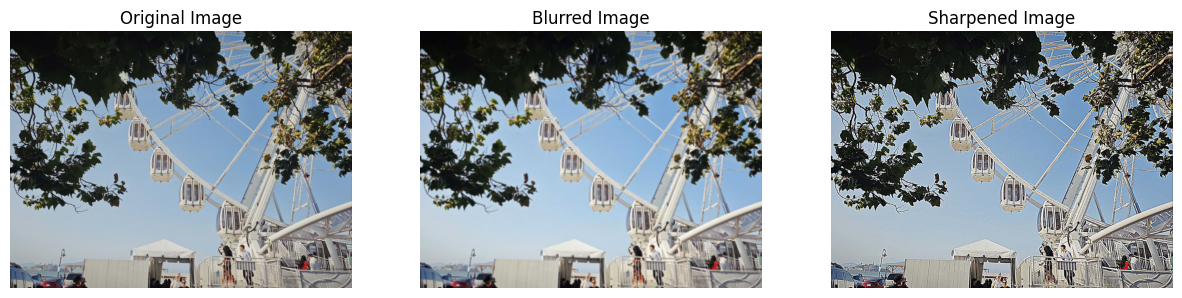

In [12]:
print('The results of ferriswheel.jpg:')
original_image, blurred_image, sharpened_image = \
    sharpen('./media/ferriswheel.jpg', (9, 9), 2, 5, False)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(blurred_image)
axes[1].set_title('Blurred Image')
axes[1].axis('off')
axes[2].imshow(sharpened_image)
axes[2].set_title('Sharpened Image')
axes[2].axis('off')
plt.show()

&emsp;&emsp;The sharpened image is not the same as the original one but I don't think this improves the accuracy or the quality.

#### Part 2.2: Hybrid Images

***IMPORTANT!!!***

&emsp;&emsp;To generate the aligned images, please run `utils.py` first! Then you could see the expected result that I realized them using the described method.

In [13]:
''' Here are some important functions for generating hybrid images. '''
# Generate a low-pass filter.
def low_pass_filter(image, kernel_size, sigma):
    return cv2.GaussianBlur(image, kernel_size, sigma)

# Generate a high-pass filter.
def high_pass_filter(image, kernel_size, sigma):
    blurred = low_pass_filter(image, kernel_size, sigma)
    return image - blurred

# Generate the hybrid image.
def hybrid(kernel_size_low, sigma_low, kernel_size_high, sigma_high, index, to_plot=True):
    im1 = skio.imread(f'./media/aligned_low{index}.jpg')
    im1 = sk.img_as_float(im1)

    im2 = skio.imread(f'./media/aligned_high{index}.jpg')
    im2 = sk.img_as_float(im2)

    low_pass_image = low_pass_filter(im1, kernel_size_low, sigma_low)
    high_pass_image = high_pass_filter(im2, kernel_size_high, sigma_high)
    hybrid_image = low_pass_image + high_pass_image

    low_pass_image = save_normalized_image(low_pass_image, f'lowpass{index}')
    high_pass_image = save_normalized_image(high_pass_image, f'highpass{index}')
    hybrid_image = save_normalized_image(hybrid_image, f'hybrid{index}')

    if to_plot:
        print('Here are the results: ')
        fig, axes = plt.subplots(1, 3, figsize=(8, 5))
        axes[0].imshow(low_pass_image)
        axes[0].set_title('Low-pass Image')
        axes[0].axis('off')
        axes[1].imshow(high_pass_image)
        axes[1].set_title('High-pass Image')
        axes[1].axis('off')
        axes[2].imshow(hybrid_image)
        axes[2].set_title('Hybrid Image')
        axes[2].axis('off')
        plt.show()
    return low_pass_image, high_pass_image, hybrid_image

# Show the original images.
def plt_original(imname1, imname2):
    im1 = skio.imread(imname1)
    im1 = sk.img_as_float(im1)
    im2 = skio.imread(imname2)
    im2 = sk.img_as_float(im2)

    print('The original images:')
    fig, axes = plt.subplots(1, 2, figsize=(5, 4))
    axes[0].imshow(im1)
    axes[0].set_title(imname1)
    axes[0].axis('off')
    axes[1].imshow(im2)
    axes[1].set_title(imname2)
    axes[1].axis('off')
    plt.show()

##### ''DerekPicture.jpg'' & ''nutmeg.jpg''

The original images:


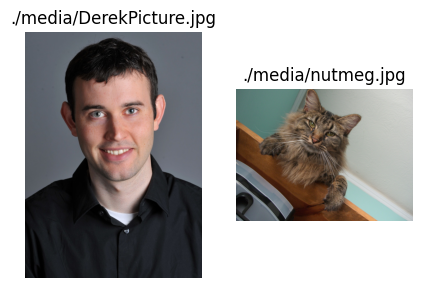

In [14]:
plt_original('./media/DerekPicture.jpg', './media/nutmeg.jpg')

Here are the results: 


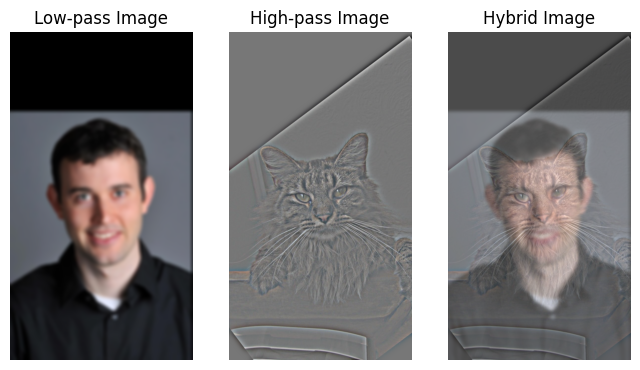

In [15]:
low_pass_image, high_pass_image, hybrid_image = hybrid((25, 25), 7, (81, 81), 11, 1)

##### ''Monroe.png'' & ''Einstein.png''

The original images:


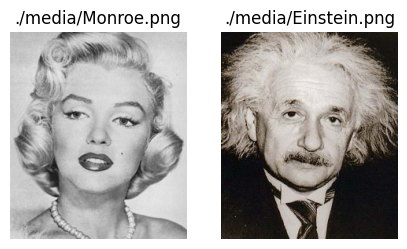

In [16]:
plt_original('./media/Monroe.png', './media/Einstein.png')

Here are the results: 


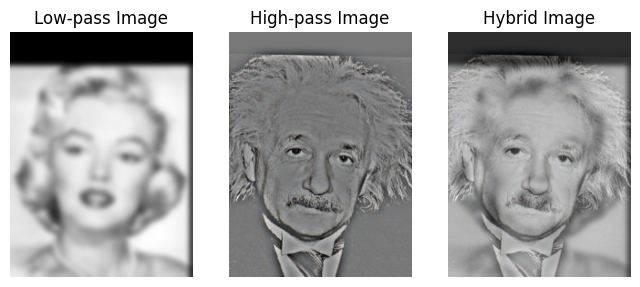

In [17]:
low_pass_image, high_pass_image, hybrid_image = hybrid((15, 15), 3, (25, 25), 5, 2)

##### ''wolf.jpg'' & ''panda.jpg''

&emsp;&emsp;As mentioned in the project description, the alignment is important because it affects the perceptual grouping. This is an example for failures. The facial features of the wolf and the panda are so different that they could not align well. In the hybrid image, you could see both the wolf's and the panda's nose and the panda's mouth even overlaps with the nose of the wolf. That is a huge disaster!

The original images:


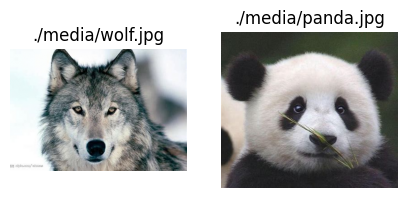

In [18]:
plt_original('./media/wolf.jpg', './media/panda.jpg')

Here are the results: 


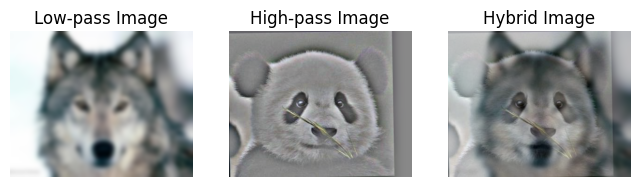

In [19]:
low_pass_image, high_pass_image, hybrid_image = hybrid((25, 25), 5, (81, 81), 11, 3)

##### ''dog.jpg'' & ''cat.jpg''

The original images:


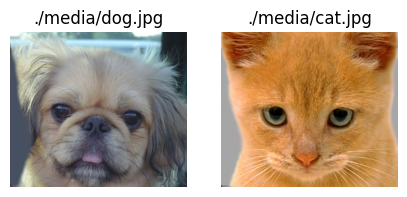

In [20]:
plt_original('./media/dog.jpg', './media/cat.jpg')

Here are the results: 


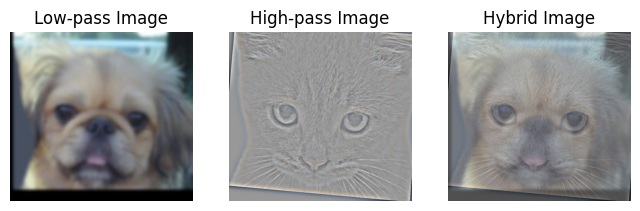

In [21]:
# Set the parameters for generating the hybrid image.
kernel_size_low = (49, 49)
kernel_size_high = (49, 49)
sigma_low = 3
sigma_high = 5
index = 4

low_pass_image, high_pass_image, hybrid_image = \
    hybrid(kernel_size_low, sigma_low, kernel_size_high, sigma_high, index)

&emsp;&emsp;This is my favourite result and I will illustrate the process through frequency analysis.

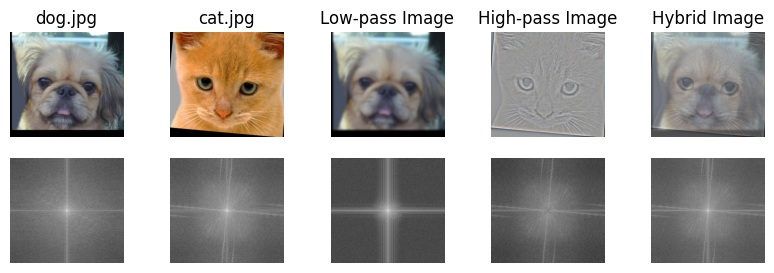

In [22]:
im1 = skio.imread(f'./media/aligned_low{index}.jpg')
im1 = sk.img_as_float(im1)

im2 = skio.imread(f'./media/aligned_high{index}.jpg')
im2 = sk.img_as_float(im2)

low_pass_image = low_pass_filter(im1, kernel_size_low, sigma_low)
high_pass_image = high_pass_filter(im2, kernel_size_high, sigma_high)
hybrid_image = low_pass_image + high_pass_image

low_pass_image = save_normalized_image(low_pass_image, f'lowpass{index}')
high_pass_image = save_normalized_image(high_pass_image, f'highpass{index}')
hybrid_image = save_normalized_image(hybrid_image, f'hybrid{index}')

fig, axes = plt.subplots(2, 5, figsize=(10, 3))
axes[0, 0].imshow(im1)
axes[0, 0].set_title('dog.jpg')
axes[0, 0].axis('off')
axes[0, 1].imshow(im2)
axes[0, 1].set_title('cat.jpg')
axes[0, 1].axis('off')
axes[0, 2].imshow(low_pass_image)
axes[0, 2].set_title('Low-pass Image')
axes[0, 2].axis('off')
axes[0, 3].imshow(high_pass_image)
axes[0, 3].set_title('High-pass Image')
axes[0, 3].axis('off')
axes[0, 4].imshow(hybrid_image)
axes[0, 4].set_title('Hybrid Image')
axes[0, 4].axis('off')
axes[1, 0].imshow(np.log(np.abs(np.fft.fftshift\
                        (np.fft.fft2(im1[:,:,2])))), cmap='grey')
axes[1, 0].axis('off')
axes[1, 1].imshow(np.log(np.abs(np.fft.fftshift\
                        (np.fft.fft2(im2[:,:,2])))), cmap='grey')
axes[1, 1].axis('off')
axes[1, 2].imshow(np.log(np.abs(np.fft.fftshift\
                        (np.fft.fft2(low_pass_image[:,:,2])))), cmap='grey')
axes[1, 2].axis('off')
axes[1, 3].imshow(np.log(np.abs(np.fft.fftshift\
                        (np.fft.fft2(high_pass_image[:,:,2])))), cmap='grey')
axes[1, 3].axis('off')
axes[1, 4].imshow(np.log(np.abs(np.fft.fftshift\
                        (np.fft.fft2(hybrid_image[:,:,2])))), cmap='grey')
axes[1, 4].axis('off')
plt.savefig('./output/hybrid_fft.jpg', dpi=300, bbox_inches='tight')
plt.show()

&emsp;&emsp;In addition, I would like to show that the hybrid image could lead to different interpretations at different distances in deed.

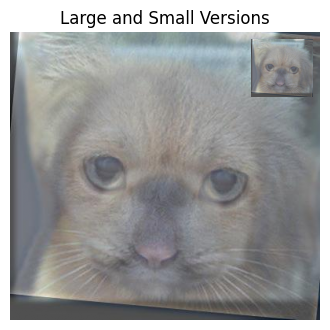

In [23]:
hybrid = skio.imread(f'./output/hybrid{index}.jpg')
hybrid = sk.img_as_float(hybrid)

fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(hybrid)
ax.set_title('Large and Small Versions')
ax.axis('off')

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
axins = inset_axes(ax, width="20%", height="20%", loc='upper right')
axins.imshow(hybrid)
axins.axis('off')

plt.savefig('./output/hybrid_pyramid.jpg', dpi=300, bbox_inches='tight')
plt.show()

## Multi-resolution Blending and the Oraple Journey

#### Part 2.3: Gaussian and Laplacian Stacks

In [24]:
# Generate a Gaussian stack.
def build_gaussian_stack(image, kernel_size, sigma, level):
    stack = []
    stack.append(image)
    for _ in range(level):
        stack.append(cv2.GaussianBlur(stack[-1], kernel_size, sigma))
    return stack

# Generate a Laplacian stack from the given Gaussian stack.
def build_laplacian_stack(gaussian_stack):
    laplacian_stack = []
    N = len(gaussian_stack) - 1
    for i in range(N):
        laplacian_stack.append(gaussian_stack[i] - gaussian_stack[i + 1])
    laplacian_stack.append(gaussian_stack[N])
    return laplacian_stack

# Normalize the image.
def normalize(stack):
    for i in range(len(stack)):
        stack[i] = (stack[i] - stack[i].min()) / (stack[i].max() - stack[i].min())

# Set up some parameters in this part.
level = 4
kernel_size = (25, 25)
sigma = 5

##### ''apple.jpeg''

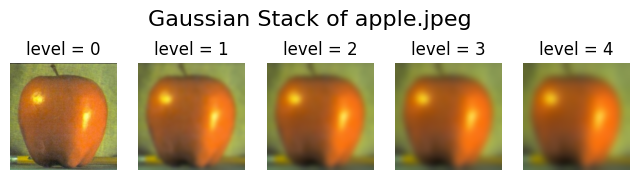

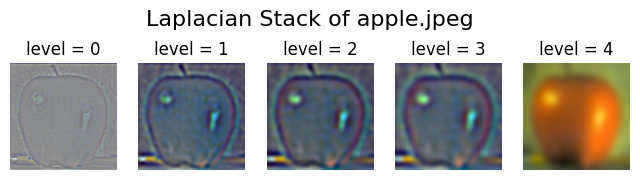

In [25]:
im = skio.imread('./media/apple.jpeg')
im = sk.img_as_float(im)

gaussian_stack = build_gaussian_stack(im, kernel_size, sigma, level)
normalize(gaussian_stack)

laplacian_stack = build_laplacian_stack(gaussian_stack)
normalize(laplacian_stack)

fig, axes = plt.subplots(1, len(gaussian_stack), figsize=(8, 2.2))
fig.suptitle('Gaussian Stack of apple.jpeg', fontsize=16)
for i in range(len(gaussian_stack)):
    axes[i].imshow(gaussian_stack[i])
    axes[i].set_title(f'level = {i}')
    axes[i].axis('off')
plt.savefig('./output/gaussian_apple.jpg', dpi=300, bbox_inches='tight')
plt.show()

fig, axes = plt.subplots(1, len(laplacian_stack), figsize=(8, 2.2))
fig.suptitle('Laplacian Stack of apple.jpeg', fontsize=16)
for i in range(len(laplacian_stack)):
    axes[i].imshow(laplacian_stack[i])
    axes[i].set_title(f'level = {i}')
    axes[i].axis('off')
plt.savefig('./output/laplacian_apple.jpg', dpi=300, bbox_inches='tight')
plt.show()

##### ''orange.jpeg''

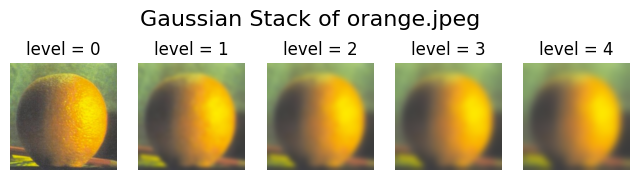

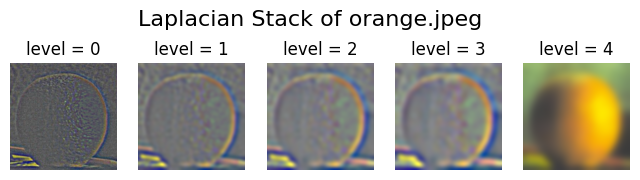

In [26]:
im = skio.imread('./media/orange.jpeg')
im = sk.img_as_float(im)

gaussian_stack = build_gaussian_stack(im, kernel_size, sigma, level)
normalize(gaussian_stack)

laplacian_stack = build_laplacian_stack(gaussian_stack)
normalize(laplacian_stack)

fig, axes = plt.subplots(1, len(gaussian_stack), figsize=(8, 2.2))
fig.suptitle('Gaussian Stack of orange.jpeg', fontsize=16)
for i in range(len(gaussian_stack)):
    axes[i].imshow(gaussian_stack[i])
    axes[i].set_title(f'level = {i}')
    axes[i].axis('off')
plt.savefig('./output/gaussian_orange.jpg', dpi=300, bbox_inches='tight')
plt.show()

fig, axes = plt.subplots(1, len(laplacian_stack), figsize=(8, 2.2))
fig.suptitle('Laplacian Stack of orange.jpeg', fontsize=16)
for i in range(len(laplacian_stack)):
    axes[i].imshow(laplacian_stack[i])
    axes[i].set_title(f'level = {i}')
    axes[i].axis('off')
plt.savefig('./output/laplacian_orange.jpg', dpi=300, bbox_inches='tight')
plt.show()

#### Part 2.4: Multiresolution Blending

##### Apple + Orange = Oraple!

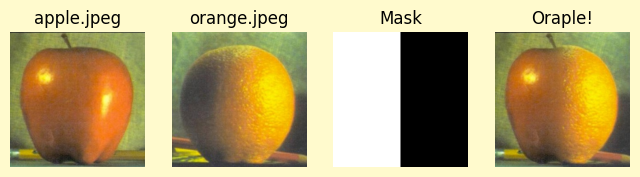

In [27]:
# Set the level of stacks for generating the blended image.
level = 11

# Build the Laplacian stack for the first image.
im1 = skio.imread('./media/apple.jpeg')
im1 = sk.img_as_float(im1)
gaussian_stack1 = build_gaussian_stack(im1, (3, 3), 1, level)
laplacian_stack1 = build_laplacian_stack(gaussian_stack1)

# Build the Laplacian stack for the second image.
im2 = skio.imread('./media/orange.jpeg')
im2 = sk.img_as_float(im2)
gaussian_stack2 = build_gaussian_stack(im2, (25, 25), 5, level)
laplacian_stack2 = build_laplacian_stack(gaussian_stack2)

# Build the mask and the corresponding stack.
mask = np.ones(im1.shape)
mask[:, mask.shape[1]//2:,:] = 0
mask_gaussian_stack = build_gaussian_stack(mask, (49, 49), 9, level)

# Build the blended stack and generate the blended image from the stack.
blend_stack_oraple = []
blend_imgs = []
for l1, l2, m in zip(laplacian_stack1, laplacian_stack2, mask_gaussian_stack):
    blend_stack_oraple.append(l1 * m + l2 * (1 - m))
blend_img = np.zeros(im1.shape)
reverse_stack = reversed(blend_stack_oraple)
for laplacian in reverse_stack:
    blend_img = laplacian + blend_img
    blend_imgs.append(blend_img)
blend_img = (blend_img - blend_img.min()) / (blend_img.max() - blend_img.min())

fig, axes = plt.subplots(1, 4, figsize=(8, 4))
fig.patch.set_facecolor('#fffacd')
axes[0].imshow(im1)
axes[0].set_title('apple.jpeg')
axes[0].axis('off')
axes[1].imshow(im2)
axes[1].set_title('orange.jpeg')
axes[1].axis('off')
axes[2].imshow(mask)
axes[2].set_title('Mask')
axes[2].axis('off')
axes[3].imshow(blend_img)
axes[3].set_title('Oraple!')
axes[3].axis('off')
plt.savefig('./output/oraple.jpg', dpi=300, bbox_inches='tight')
plt.show()

##### Star + Mountain = Starry Night!

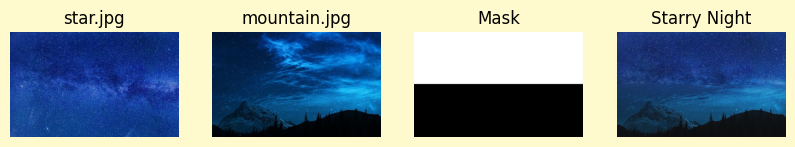

In [28]:
# Set the level of stacks for generating the blended image.
level = 10

# Build the Laplacian stack for the first image.
im1 = skio.imread('./media/star.jpg')
im1 = sk.img_as_float(im1)
gaussian_stack1 = build_gaussian_stack(im1, (101, 101), 50, level)
laplacian_stack1 = build_laplacian_stack(gaussian_stack1)

# Build the Laplacian stack for the second image.
im2 = skio.imread('./media/mountain.jpg')
im2 = sk.img_as_float(im2)
gaussian_stack2 = build_gaussian_stack(im2, (15, 15), 20, level)
laplacian_stack2 = build_laplacian_stack(gaussian_stack2)

# Build the mask and the corresponding stack.
mask = np.ones(im1.shape)
mask[mask.shape[0]//2:, :, :] = 0
mask_gaussian_stack = build_gaussian_stack(mask, (81, 81), 50, level)

# Build the blended stack and generate the blended image from the stack.
blend_stack = []
for l1, l2, m in zip(laplacian_stack1, laplacian_stack2, mask_gaussian_stack):
    blend_stack.append(l1 * m + l2 * (1 - m))
blend_img = np.zeros(im1.shape)
reverse_stack = reversed(blend_stack)
for laplacian in reverse_stack:
    blend_img = laplacian + blend_img
blend_img = (blend_img - blend_img.min()) / (blend_img.max() - blend_img.min())

fig, axes = plt.subplots(1, 4, figsize=(10, 4))
fig.patch.set_facecolor('#fffacd')
axes[0].imshow(im1)
axes[0].set_title('star.jpg')
axes[0].axis('off')
axes[1].imshow(im2)
axes[1].set_title('mountain.jpg')
axes[1].axis('off')
axes[2].imshow(mask)
axes[2].set_title('Mask')
axes[2].axis('off')
axes[3].imshow(blend_img)
axes[3].set_title('Starry Night')
axes[3].axis('off')
plt.savefig('./output/starrynight.jpg', dpi=300, bbox_inches='tight')
plt.show()

##### Chandler + Monica = Chanica!

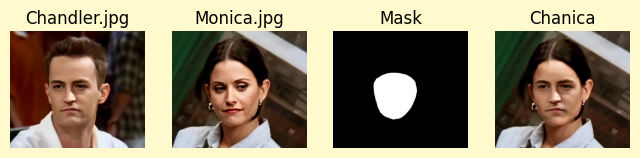

In [29]:
# Set the level of stacks for generating the blended image.
level = 7

# Build the Laplacian stack for the first image.
im1 = skio.imread('./media/Chandler.jpg')
im1 = sk.img_as_float(im1)
gaussian_stack1 = build_gaussian_stack(im1, (25, 25), 3, level)
laplacian_stack1 = build_laplacian_stack(gaussian_stack1)

# Build the Laplacian stack for the second image.
im2 = skio.imread('./media/Monica.jpg')
im2 = sk.img_as_float(im2)
gaussian_stack2 = build_gaussian_stack(im2, (15, 15), 3, level)
laplacian_stack2 = build_laplacian_stack(gaussian_stack2)

# Build the mask and the corresponding stack.
mask = skio.imread('./media/cm_mask.jpg')
mask = sk.img_as_float(mask)
mask_gaussian_stack = build_gaussian_stack(mask, (25, 25), 15, level)

# Build the blended stack and generate the blended image from the stack.
blend_stack = []
for l1, l2, m in zip(laplacian_stack1, laplacian_stack2, mask_gaussian_stack):
    blend_stack.append(l1 * m + l2 * (1 - m))
blend_img = np.zeros(im1.shape)
reverse_stack = reversed(blend_stack)
for laplacian in reverse_stack:
    blend_img = laplacian + blend_img
blend_img = (blend_img - blend_img.min()) / (blend_img.max() - blend_img.min())

fig, axes = plt.subplots(1, 4, figsize=(8, 4))
fig.patch.set_facecolor('#fffacd')
axes[0].imshow(im1)
axes[0].set_title('Chandler.jpg')
axes[0].axis('off')
axes[1].imshow(im2)
axes[1].set_title('Monica.jpg')
axes[1].axis('off')
axes[2].imshow(mask)
axes[2].set_title('Mask')
axes[2].axis('off')
axes[3].imshow(blend_img)
axes[3].set_title('Chanica')
axes[3].axis('off')
plt.savefig('./output/Chanica.jpg', dpi=300, bbox_inches='tight')
plt.show()

&emsp;&emsp;Actually, my favourate result is the oraple, so I will illustrate the process for you.

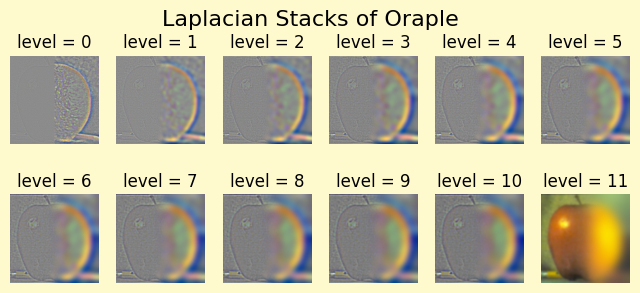

In [30]:
normalize(blend_stack_oraple)
fig, axes = plt.subplots(2, 6, figsize=(8, 3.3))
fig.suptitle('Laplacian Stacks of Oraple', fontsize=16)
fig.patch.set_facecolor('#fffacd')
for i in range(6):
    axes[0, i].imshow(blend_stack_oraple[i], cmap='grey')
    axes[0, i].set_title(f'level = {i}')
    axes[0, i].axis('off')
    axes[1, i].imshow(blend_stack_oraple[i + 6], cmap='grey')
    axes[1, i].set_title(f'level = {i + 6}')
    axes[1, i].axis('off')
plt.savefig('./output/laplacian_oraple.jpg', dpi=300, bbox_inches='tight')
plt.show()